In [1]:
from data import Cityscapes as dataset
from data.utils import enet_weighing
from models.enet import ENet
from metric.iou import IoU
import utils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import transforms as ext_transforms
from PIL import Image

In [2]:
# Display the example of model structure

model = ENet(20).to("cuda:0")
optimizer = optim.Adam(model.parameters())
# Load the previoulsy saved model state to the ENet model
model = utils.load_checkpoint(model, optimizer, 'save/eNet_cityscapes_batch10/', 'enet_20')[0]
print(model)

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_prelu): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv3)

In [3]:
device = "cuda:0"

class Test:
    def __init__(self, model, data_loader, criterion, metric, device):
        self.model = model
        self.data_loader = data_loader
        self.criterion = criterion
        self.metric = metric
        self.device = device

    def run_epoch(self, iteration_loss=False):
        self.model.eval()
        epoch_loss = 0.0
        self.metric.reset()
        for step, batch_data in enumerate(self.data_loader):
            # Get the inputs and labels
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            with torch.no_grad():
                # Forward propagation
                outputs = self.model(inputs)

                # Loss computation
                loss = self.criterion(outputs, labels)

            # Keep track of loss for current epoch
            epoch_loss += loss.item()

            # Keep track of evaluation the metric
            self.metric.add(outputs.detach(), labels.detach())

            if iteration_loss:
                print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

        return epoch_loss / len(self.data_loader), self.metric.value()
    
def test(model, test_loader, class_weights, class_encoding):
    print("\nTesting...\n")

    num_classes = len(class_encoding)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    ignore_index = list(class_encoding).index('unlabeled')

    metric = IoU(num_classes, ignore_index=ignore_index)

    # Test the trained model on the test set
    test = Test(model, test_loader, criterion, metric, device)
    print(">>>> Running test dataset")

    loss, (iou, miou) = test.run_epoch()
    class_iou = dict(zip(class_encoding.keys(), iou))
    print(">>>> Avg. loss: {0:.4f} | Mean IoU: {1:.4f}".format(loss, miou))

    # Print per class IoU
    for key, class_iou in zip(class_encoding.keys(), iou):
        print("{0}: {1:.4f}".format(key, class_iou))
    
    return loss, miou, iou

In [6]:
def test_enet_citiscapes(save_dir, model_name_list, width, height):
    dataset_dir = 'dataset/Cityscapes/'
    batch_size = 1
    num_classes = 20
    
    image_transform = transforms.Compose(
        [transforms.Resize((height, width)),
         transforms.ToTensor()])

    label_transform = transforms.Compose([
        transforms.Resize((height, width), Image.NEAREST),
        ext_transforms.PILToLongTensor()
    ])
    
    test_set = dataset(
        dataset_dir,
        mode='val',
        transform=image_transform,
        label_transform=label_transform)
    test_loader = data.DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=12)

    train_set = dataset(
        dataset_dir,
        transform=image_transform,
        label_transform=label_transform)
    train_loader = data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=12)

    # Get encoding between pixel valus in label images and RGB colors
    class_encoding = train_set.color_encoding

    class_weights = enet_weighing(train_loader, num_classes)
    if class_weights is not None:
        class_weights = torch.from_numpy(class_weights).float().to(device)
    # Set the weight of the unlabeled class to 0
    ignore_index = list(class_encoding).index('unlabeled')
    class_weights[ignore_index] = 0
    
    loss_list = []
    miou_list = []
    iou_list = []

    for model_name in model_name_list:
        model = ENet(num_classes).to(device)
        optimizer = optim.Adam(model.parameters())

        # Load the previoulsy saved model state to the ENet model
        model = utils.load_checkpoint(model, optimizer, save_dir, model_name)[0]

        loss, miou, iou = test(model, test_loader, class_weights, class_encoding)
        print('The model_name is: ',model_name)
        
        loss_list.append(loss)
        miou_list.append(miou)
        iou_list.append(iou)
        
    return loss_list, miou_list, iou_list

In [7]:
model_name_list = []
for i in range(15):
    model_name_list.append('enet_'+str((i+1)*20))

loss_batch10_480_list, miou_batch10_480_list, iou_batch10_480_list = test_enet_citiscapes('save/eNet_cityscapes_batch10/', model_name_list, 480, 360)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7579 | Mean IoU: 0.3818
unlabeled: nan
road: 0.8981
sidewalk: 0.5235
building: 0.7626
wall: 0.2646
fence: 0.1446
pole: 0.2330
traffic_light: 0.1046
traffic_sign: 0.2760
vegetation: 0.8060
terrain: 0.4289
sky: 0.8348
person: 0.3853
rider: 0.0007
car: 0.7929
truck: 0.1221
bus: 0.2416
train: 0.0179
motorcycle: 0.0012
bicycle: 0.4161
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7474 | Mean IoU: 0.4308
unlabeled: nan
road: 0.9052
sidewalk: 0.5455
building: 0.7994
wall: 0.2592
fence: 0.2015
pole: 0.2781
traffic_light: 0.2409
traffic_sign: 0.3569
vegetation: 0.8037
terrain: 0.4332
sky: 0.8428
person: 0.4496
rider: 0.2179
car: 0.7862
truck: 0.1733
bus: 0.1611
train: 0.1483
motorcycle: 0.1311
bicycle: 0.4514
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6592 | Mean IoU: 0.4525
unlabeled: nan
road: 0.9248
sidewalk: 0.5999
building: 0.7790
wall: 0.2682
fence: 0.2

In [8]:
loss_batch10_512_list, miou_batch10_512_list, iou_batch10_512_list = test_enet_citiscapes('save/eNet_cityscapes_batch10_512/', model_name_list, 512, 256)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.8004 | Mean IoU: 0.3793
unlabeled: nan
road: 0.9228
sidewalk: 0.5649
building: 0.7432
wall: 0.2286
fence: 0.1138
pole: 0.2441
traffic_light: 0.1480
traffic_sign: 0.2387
vegetation: 0.7949
terrain: 0.4072
sky: 0.8374
person: 0.3824
rider: 0.0000
car: 0.7530
truck: 0.0964
bus: 0.3156
train: 0.0113
motorcycle: 0.0319
bicycle: 0.3722
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7546 | Mean IoU: 0.4204
unlabeled: nan
road: 0.9343
sidewalk: 0.6022
building: 0.7551
wall: 0.2370
fence: 0.1675
pole: 0.2748
traffic_light: 0.2427
traffic_sign: 0.2647
vegetation: 0.8082
terrain: 0.4618
sky: 0.7798
person: 0.4014
rider: 0.1924
car: 0.7858
truck: 0.2058
bus: 0.2329
train: 0.1361
motorcycle: 0.1097
bicycle: 0.3952
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7315 | Mean IoU: 0.4392
unlabeled: nan
road: 0.9388
sidewalk: 0.6067
building: 0.7653
wall: 0.2778
fence: 0.1

In [9]:
loss_batch4_480_list, miou_batch4_480_list, iou_batch4_480_list = test_enet_citiscapes('save/eNet_cityscapes_batch4/', model_name_list, 480, 360)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7214 | Mean IoU: 0.3926
unlabeled: nan
road: 0.9273
sidewalk: 0.5894
building: 0.7610
wall: 0.2428
fence: 0.1632
pole: 0.2658
traffic_light: 0.2243
traffic_sign: 0.3152
vegetation: 0.8129
terrain: 0.4218
sky: 0.8355
person: 0.3949
rider: 0.0545
car: 0.7826
truck: 0.1496
bus: 0.0231
train: 0.0397
motorcycle: 0.0806
bicycle: 0.3743
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6833 | Mean IoU: 0.4455
unlabeled: nan
road: 0.9341
sidewalk: 0.6224
building: 0.7950
wall: 0.3439
fence: 0.2187
pole: 0.2993
traffic_light: 0.2199
traffic_sign: 0.3959
vegetation: 0.8211
terrain: 0.4288
sky: 0.8384
person: 0.4177
rider: 0.1900
car: 0.8057
truck: 0.2350
bus: 0.1516
train: 0.1413
motorcycle: 0.1748
bicycle: 0.4302
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6558 | Mean IoU: 0.4672
unlabeled: nan
road: 0.9377
sidewalk: 0.6361
building: 0.7541
wall: 0.2103
fence: 0.1

In [11]:
loss_batch4_1024_list, miou_batch4_1024_list, iou_batch4_1024_list = test_enet_citiscapes('save/eNet_cityscapes_batch4_1024/', model_name_list, 1024, 512)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7128 | Mean IoU: 0.4269
unlabeled: nan
road: 0.9321
sidewalk: 0.6116
building: 0.7792
wall: 0.2284
fence: 0.2265
pole: 0.3584
traffic_light: 0.2444
traffic_sign: 0.4243
vegetation: 0.8412
terrain: 0.4693
sky: 0.8933
person: 0.4021
rider: 0.2272
car: 0.7596
truck: 0.0113
bus: 0.1799
train: 0.0235
motorcycle: 0.0609
bicycle: 0.4371
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.5651 | Mean IoU: 0.4824
unlabeled: nan
road: 0.9351
sidewalk: 0.6277
building: 0.8031
wall: 0.2982
fence: 0.3044
pole: 0.3903
traffic_light: 0.3127
traffic_sign: 0.4695
vegetation: 0.8483
terrain: 0.4519
sky: 0.8720
person: 0.4761
rider: 0.3305
car: 0.8409
truck: 0.1958
bus: 0.2663
train: 0.0723
motorcycle: 0.1533
bicycle: 0.5176
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.5883 | Mean IoU: 0.4915
unlabeled: nan
road: 0.9418
sidewalk: 0.6492
building: 0.8146
wall: 0.3321
fence: 0.2

In [14]:
sub_model_name_list = []
for i in range(7):
    sub_model_name_list.append('enet_'+str((i+1)*20))
    
loss_batch4_1024_lr8_list, miou_batch4_1024_lr8_list, iou_batch4_1024_lr8_list = test_enet_citiscapes('save/eNet_cityscapes_batch4_1024_lr8/', sub_model_name_list, 1024, 512)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6630 | Mean IoU: 0.4188
unlabeled: nan
road: 0.9167
sidewalk: 0.5825
building: 0.7330
wall: 0.2054
fence: 0.1586
pole: 0.3475
traffic_light: 0.2039
traffic_sign: 0.3695
vegetation: 0.8370
terrain: 0.4749
sky: 0.8845
person: 0.4739
rider: 0.1924
car: 0.8069
truck: 0.0138
bus: 0.1665
train: 0.0623
motorcycle: 0.0233
bicycle: 0.5046
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6839 | Mean IoU: 0.4247
unlabeled: nan
road: 0.9318
sidewalk: 0.6504
building: 0.6558
wall: 0.1299
fence: 0.2102
pole: 0.3872
traffic_light: 0.2651
traffic_sign: 0.4287
vegetation: 0.8368
terrain: 0.4398
sky: 0.8714
person: 0.5034
rider: 0.3200
car: 0.7439
truck: 0.0858
bus: 0.0317
train: 0.0069
motorcycle: 0.1007
bicycle: 0.4692
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.5990 | Mean IoU: 0.4857
unlabeled: nan
road: 0.9336
sidewalk: 0.6248
building: 0.7855
wall: 0.3176
fence: 0.3

In [18]:
loss_batch4_1024_lr10_list, miou_batch4_1024_lr10_list, iou_batch4_1024_lr10_list = test_enet_citiscapes('save/eNet_cityscapes_batch4_1024_lr10/', sub_model_name_list, 1024, 512)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7395 | Mean IoU: 0.4157
unlabeled: nan
road: 0.9402
sidewalk: 0.6350
building: 0.7586
wall: 0.1582
fence: 0.1489
pole: 0.3675
traffic_light: 0.3397
traffic_sign: 0.4243
vegetation: 0.8274
terrain: 0.4177
sky: 0.8786
person: 0.4380
rider: 0.0570
car: 0.8030
truck: 0.1852
bus: 0.0170
train: 0.0011
motorcycle: 0.0378
bicycle: 0.4638
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6149 | Mean IoU: 0.4730
unlabeled: nan
road: 0.9412
sidewalk: 0.6532
building: 0.7808
wall: 0.2222
fence: 0.2019
pole: 0.3734
traffic_light: 0.3207
traffic_sign: 0.4524
vegetation: 0.8420
terrain: 0.4608
sky: 0.8314
person: 0.5242
rider: 0.2817
car: 0.8051
truck: 0.1757
bus: 0.3370
train: 0.1634
motorcycle: 0.1211
bicycle: 0.4979
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.5807 | Mean IoU: 0.4890
unlabeled: nan
road: 0.9323
sidewalk: 0.6214
building: 0.8120
wall: 0.3243
fence: 0.2

In [19]:
loss_batch4_1024_lr12_list, miou_batch4_1024_lr12_list, iou_batch4_1024_lr12_list = test_enet_citiscapes('save/eNet_cityscapes_batch4_1024_lr12/', sub_model_name_list, 1024, 512)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6913 | Mean IoU: 0.4216
unlabeled: nan
road: 0.9325
sidewalk: 0.6116
building: 0.7712
wall: 0.2566
fence: 0.2184
pole: 0.3189
traffic_light: 0.3125
traffic_sign: 0.3780
vegetation: 0.8375
terrain: 0.4675
sky: 0.7050
person: 0.4520
rider: 0.2021
car: 0.7782
truck: 0.1108
bus: 0.1535
train: 0.0498
motorcycle: 0.0051
bicycle: 0.4500
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7393 | Mean IoU: 0.4416
unlabeled: nan
road: 0.9420
sidewalk: 0.6245
building: 0.7772
wall: 0.2778
fence: 0.2424
pole: 0.3612
traffic_light: 0.2807
traffic_sign: 0.4086
vegetation: 0.8214
terrain: 0.4168
sky: 0.8738
person: 0.5088
rider: 0.2512
car: 0.7461
truck: 0.1329
bus: 0.1897
train: 0.1012
motorcycle: 0.0359
bicycle: 0.3973
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.6555 | Mean IoU: 0.4260
unlabeled: nan
road: 0.9209
sidewalk: 0.5745
building: 0.7359
wall: 0.2398
fence: 0.2

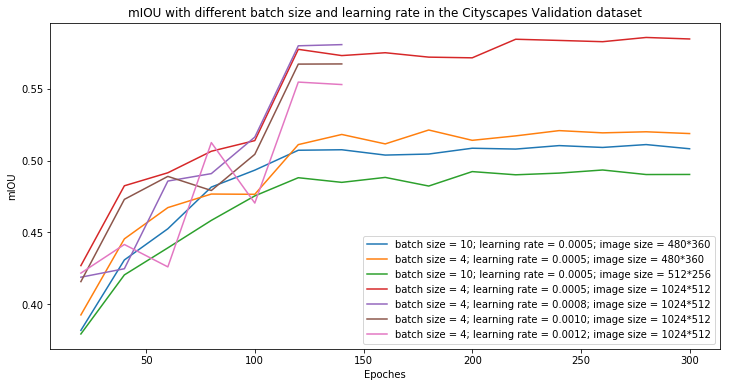

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,miou_batch10_480_list, label="batch size = 10; learning rate = 0.0005; image size = 480*360")
ax1.plot(time_list,miou_batch4_480_list, label="batch size = 4; learning rate = 0.0005; image size = 480*360")
ax1.plot(time_list,miou_batch10_512_list, label="batch size = 10; learning rate = 0.0005; image size = 512*256")
ax1.plot(time_list,miou_batch4_1024_list, label="batch size = 4; learning rate = 0.0005; image size = 1024*512")
ax1.plot(time_list[:7],miou_batch4_1024_lr8_list, label="batch size = 4; learning rate = 0.0008; image size = 1024*512")
ax1.plot(time_list[:7],miou_batch4_1024_lr10_list, label="batch size = 4; learning rate = 0.0010; image size = 1024*512")
ax1.plot(time_list[:7],miou_batch4_1024_lr12_list, label="batch size = 4; learning rate = 0.0012; image size = 1024*512")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("mIOU")
ax1.set_title("mIOU with different batch size and learning rate in the Cityscapes Validation dataset")
plt.legend(loc='lower right')
# plt.show()
fig.savefig("Cityscapes_0.png")

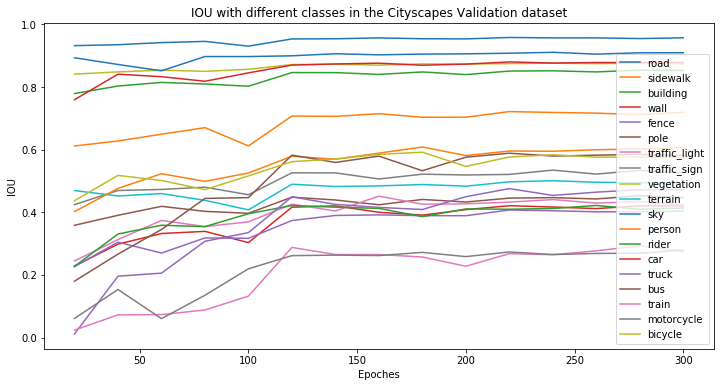

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)

import numpy as np
iou_batch10 = np.array(iou_batch4_1024_list).T

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,iou_batch10[1], label="road")
ax1.plot(time_list,iou_batch10[2], label="sidewalk")
ax1.plot(time_list,iou_batch10[3], label="building")
ax1.plot(time_list,iou_batch10[4], label="wall")
ax1.plot(time_list,iou_batch10[5], label="fence")
ax1.plot(time_list,iou_batch10[6], label="pole")
ax1.plot(time_list,iou_batch10[7], label="traffic_light")
ax1.plot(time_list,iou_batch10[8], label="traffic_sign")
ax1.plot(time_list,iou_batch10[9], label="vegetation")
ax1.plot(time_list,iou_batch10[10], label="terrain")
ax1.plot(time_list,iou_batch10[11], label="sky")
ax1.plot(time_list,iou_batch10[12], label="person")
ax1.plot(time_list,iou_batch10[13], label="rider")
ax1.plot(time_list,iou_batch10[14], label="car")
ax1.plot(time_list,iou_batch10[15], label="truck")
ax1.plot(time_list,iou_batch10[16], label="bus")
ax1.plot(time_list,iou_batch10[17], label="train")
ax1.plot(time_list,iou_batch10[18], label="motorcycle")
ax1.plot(time_list,iou_batch10[19], label="bicycle")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("IOU")
ax1.set_title("IOU with different classes in the Cityscapes Validation dataset")
plt.legend(loc='lower right')
# plt.show()
fig.savefig("Cityscapes_1.png")

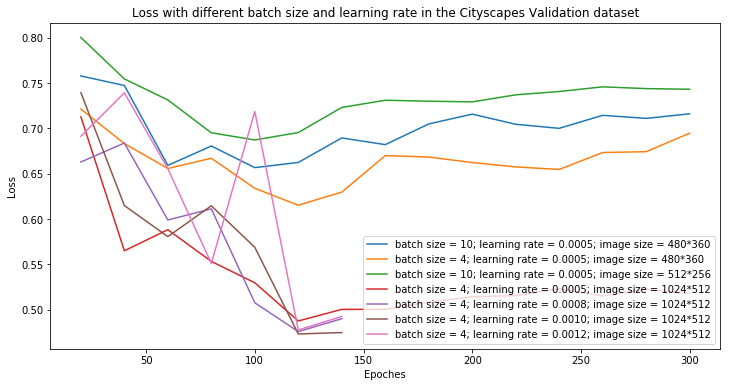

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,loss_batch10_480_list, label="batch size = 10; learning rate = 0.0005; image size = 480*360")
ax1.plot(time_list,loss_batch4_480_list, label="batch size = 4; learning rate = 0.0005; image size = 480*360")
ax1.plot(time_list,loss_batch10_512_list, label="batch size = 10; learning rate = 0.0005; image size = 512*256")
ax1.plot(time_list,loss_batch4_1024_list, label="batch size = 4; learning rate = 0.0005; image size = 1024*512")
ax1.plot(time_list[:7],loss_batch4_1024_lr8_list, label="batch size = 4; learning rate = 0.0008; image size = 1024*512")
ax1.plot(time_list[:7],loss_batch4_1024_lr10_list, label="batch size = 4; learning rate = 0.0010; image size = 1024*512")
ax1.plot(time_list[:7],loss_batch4_1024_lr12_list, label="batch size = 4; learning rate = 0.0012; image size = 1024*512")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("Loss")
ax1.set_title("Loss with different batch size and learning rate in the Cityscapes Validation dataset")
plt.legend(loc='lower right')
# plt.show()
fig.savefig("Cityscapes_2.png")

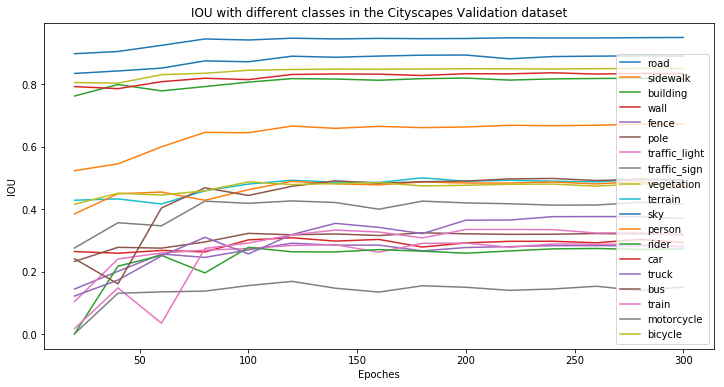

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)

import numpy as np
iou_batch10 = np.array(iou_batch10_480_list).T

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,iou_batch10[1], label="road")
ax1.plot(time_list,iou_batch10[2], label="sidewalk")
ax1.plot(time_list,iou_batch10[3], label="building")
ax1.plot(time_list,iou_batch10[4], label="wall")
ax1.plot(time_list,iou_batch10[5], label="fence")
ax1.plot(time_list,iou_batch10[6], label="pole")
ax1.plot(time_list,iou_batch10[7], label="traffic_light")
ax1.plot(time_list,iou_batch10[8], label="traffic_sign")
ax1.plot(time_list,iou_batch10[9], label="vegetation")
ax1.plot(time_list,iou_batch10[10], label="terrain")
ax1.plot(time_list,iou_batch10[11], label="sky")
ax1.plot(time_list,iou_batch10[12], label="person")
ax1.plot(time_list,iou_batch10[13], label="rider")
ax1.plot(time_list,iou_batch10[14], label="car")
ax1.plot(time_list,iou_batch10[15], label="truck")
ax1.plot(time_list,iou_batch10[16], label="bus")
ax1.plot(time_list,iou_batch10[17], label="train")
ax1.plot(time_list,iou_batch10[18], label="motorcycle")
ax1.plot(time_list,iou_batch10[19], label="bicycle")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("IOU")
ax1.set_title("IOU with different classes in the Cityscapes Validation dataset")
plt.legend(loc='lower right')
# plt.show()
fig.savefig("Cityscapes_3.png")

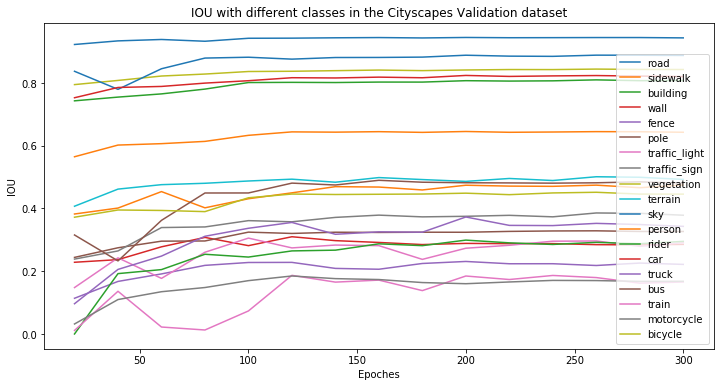

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)

import numpy as np
iou_batch10 = np.array(iou_batch10_512_list).T

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,iou_batch10[1], label="road")
ax1.plot(time_list,iou_batch10[2], label="sidewalk")
ax1.plot(time_list,iou_batch10[3], label="building")
ax1.plot(time_list,iou_batch10[4], label="wall")
ax1.plot(time_list,iou_batch10[5], label="fence")
ax1.plot(time_list,iou_batch10[6], label="pole")
ax1.plot(time_list,iou_batch10[7], label="traffic_light")
ax1.plot(time_list,iou_batch10[8], label="traffic_sign")
ax1.plot(time_list,iou_batch10[9], label="vegetation")
ax1.plot(time_list,iou_batch10[10], label="terrain")
ax1.plot(time_list,iou_batch10[11], label="sky")
ax1.plot(time_list,iou_batch10[12], label="person")
ax1.plot(time_list,iou_batch10[13], label="rider")
ax1.plot(time_list,iou_batch10[14], label="car")
ax1.plot(time_list,iou_batch10[15], label="truck")
ax1.plot(time_list,iou_batch10[16], label="bus")
ax1.plot(time_list,iou_batch10[17], label="train")
ax1.plot(time_list,iou_batch10[18], label="motorcycle")
ax1.plot(time_list,iou_batch10[19], label="bicycle")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("IOU")
ax1.set_title("IOU with different classes in the Cityscapes Validation dataset")
plt.legend(loc='lower right')
# plt.show()
fig.savefig("Cityscapes_4.png")